In [3]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import helper_functions as hp
import pandas as pd
import cv2
import matplotlib as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import gc
import skimage.util.noise as noise
#from keras import backend as K

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [4]:
import tensorflow as tf
tf.test.gpu_device_name()
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-12-05 10:21:09.731485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 10:21:10.693110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 9637 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2022-12-05 10:21:10.693780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 9636 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5
2022-12-05 10:21:10.697728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 9637 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti

True

2022-12-05 10:21:10.697901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 9636 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


## Load in planetscope dataset and create a simple CNN with it.

In [5]:
# Load in planetscope data
#K.clear_session()
planetscope_images_tif, planetscope_labels_tif = hp.dataset_reader_planetscope('planetscope_chips_90m_3class_classified_tiles')

reading in 30466 images


In [6]:
print(np.unique(planetscope_labels_tif, axis=0, return_counts=True))
print(planetscope_images_tif.max(),planetscope_images_tif.min())
print(planetscope_images_tif.dtype)
print(planetscope_images_tif.shape)

(array([1, 2, 3], dtype=uint16), array([ 6236,   308, 23922], dtype=int64))
6316.0 0.0
float32
(30466, 30, 30, 4)


In [18]:
train_images, test_images, train_labels, test_labels = train_test_split(planetscope_images_tif, planetscope_labels_tif, test_size=.2, shuffle=True)

In [19]:
df_dict = {"images": [], "labels": []}

for i in range(len(train_images)):
    df_dict["images"].append(train_images[i])
    df_dict["labels"].append(train_labels[i])

df = pd.DataFrame(data=df_dict)
df.head()

(array([1, 2, 3], dtype=uint16), array([ 6236,   308, 23922]))

In [7]:
# Shuffle labels and images and create a train test split for planetscope data
train_images, test_images, train_labels, test_labels = train_test_split(planetscope_images_tif, planetscope_labels_tif, test_size=.2, shuffle=True)

## Do oversampling and data augmentation on planetscope data

In [8]:
# Map images and labels using pandas dataframe
df_dict = {"images": [], "labels": []}

for i in range(len(train_images)):
    df_dict["images"].append(train_images[i])
    df_dict["labels"].append(train_labels[i])

df = pd.DataFrame(data=df_dict)

label_1_rows = df.loc[df['labels'] == 1]
label_2_rows = df.loc[df['labels'] == 2]
label_3_rows = df.loc[df['labels'] == 3]

print(len(label_1_rows))
print(len(label_2_rows))
print(len(label_3_rows))

4971
228
19173


In [9]:
# Oversample and data augment images from labels 1 and 2 for planetscope
new_L1_df = hp.augment_label_1(label_1_rows)
print("New label 1 images:", len(new_L1_df))

new_L2_df = hp.augment_label_2(label_2_rows)
print("New label 2 images", len(new_L2_df))

L1_L2 = pd.concat([new_L1_df, new_L2_df], ignore_index=True)
new_df = pd.concat([L1_L2, label_3_rows], ignore_index=True)

New label 1 images: 19884
New label 2 images 18240


In [10]:
# Get new planetscope images and labels from new dataframe
comb_planetscope_images = []
comb_naip_labels = []

for index, row in new_df.iterrows():
    new_image = row["images"]
    new_label = row["labels"]

    comb_planetscope_images.append(new_image)
    comb_naip_labels.append(new_label)

comb_planetscope_images = np.asarray(comb_planetscope_images)
comb_naip_labels = np.asarray(comb_naip_labels)

In [11]:
# Encode planetscope data
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(comb_naip_labels.reshape(-1, 1))
planetscope_new_labels = enc.transform(comb_naip_labels.reshape(-1, 1)).toarray().astype('uint8')

print(comb_naip_labels[0])
print(comb_naip_labels.shape)

1
(57297,)


In [12]:
# Do a train_test_split with oversampled and augmented data for planetscope
train_images, test_images, train_labels, test_labels = train_test_split(comb_planetscope_images, planetscope_new_labels, test_size=.2, shuffle=True)

In [13]:
np.unique(train_labels, axis=0, return_counts=True)

(array([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]], dtype=uint8),
 array([15326, 14610, 15901]))

In [14]:
# Create a simple model for the planetscope data
model = hp.get_simple_model(train_images[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 50)        5050      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 50)       200       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 30)        37530     
                                                                 
 batch_normalization_1 (Batc  (None, 15, 15, 30)       120       
 hNormalization)                                                 
                                                        

2022-12-05 10:21:42.053332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9637 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2022-12-05 10:21:42.053607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9636 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


In [15]:
# Calculate initial test accuracy for planetscope data.
test_init = hp.get_test_accuracy(model, test_images, test_labels)
train_init = hp.get_train_accuracy(model, train_images, train_labels)

2022-12-05 10:21:46.165556: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


accuracy: 0.332
accuracy: 0.331


In [16]:
# Train model with planetscope data
history = model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels))

Epoch 1/30
1433/1433 [==============================] - 14s 9ms/step - loss: 0.2873 - accuracy: 0.8881 - val_loss: 0.4681 - val_accuracy: 0.8156
Epoch 2/30
1433/1433 [==============================] - 13s 9ms/step - loss: 0.2299 - accuracy: 0.9103 - val_loss: 0.2549 - val_accuracy: 0.9011
Epoch 3/30
1433/1433 [==============================] - 13s 9ms/step - loss: 0.1944 - accuracy: 0.9246 - val_loss: 2.5929 - val_accuracy: 0.3940
Epoch 4/30
1433/1433 [==============================] - 13s 9ms/step - loss: 0.1744 - accuracy: 0.9340 - val_loss: 1.1241 - val_accuracy: 0.8281
Epoch 5/30
1433/1433 [==============================] - 13s 9ms/step - loss: 0.1297 - accuracy: 0.9529 - val_loss: 2.0342 - val_accuracy: 0.6996
Epoch 6/30
1433/1433 [==============================] - 13s 9ms/step - loss: 0.1127 - accuracy: 0.9605 - val_loss: 0.6869 - val_accuracy: 0.8069
Epoch 7/30
1433/1433 [==============================] - 13s 9ms/step - loss: 0.0865 - accuracy: 0.9698 - val_loss: 0.3675 - val_ac

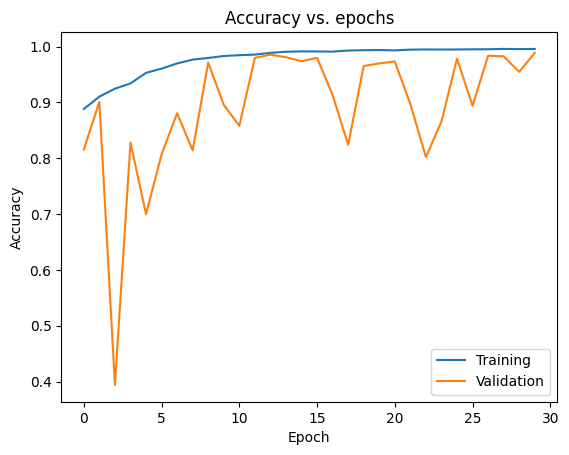

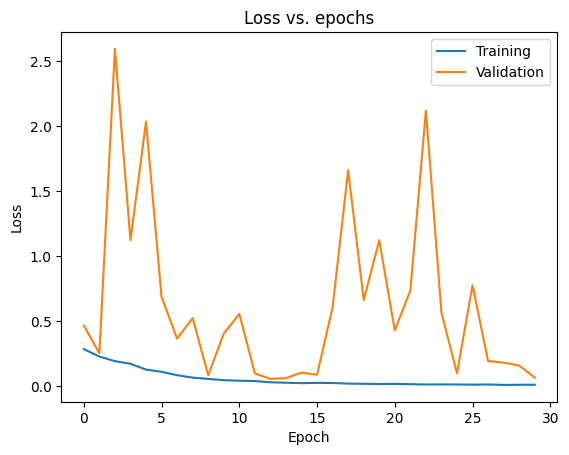

In [17]:
# Plot accuracy for planetscope data
hp.plot_accuracy(history)
hp.plot_loss(history)

In [18]:
# Get accuracy after training the planetscope model once
test_first = hp.get_test_accuracy(model, test_images, test_labels)
train_first = hp.get_train_accuracy(model, train_images, train_labels)

accuracy: 0.989
accuracy: 0.997


[1 2 0 ... 1 1 1]


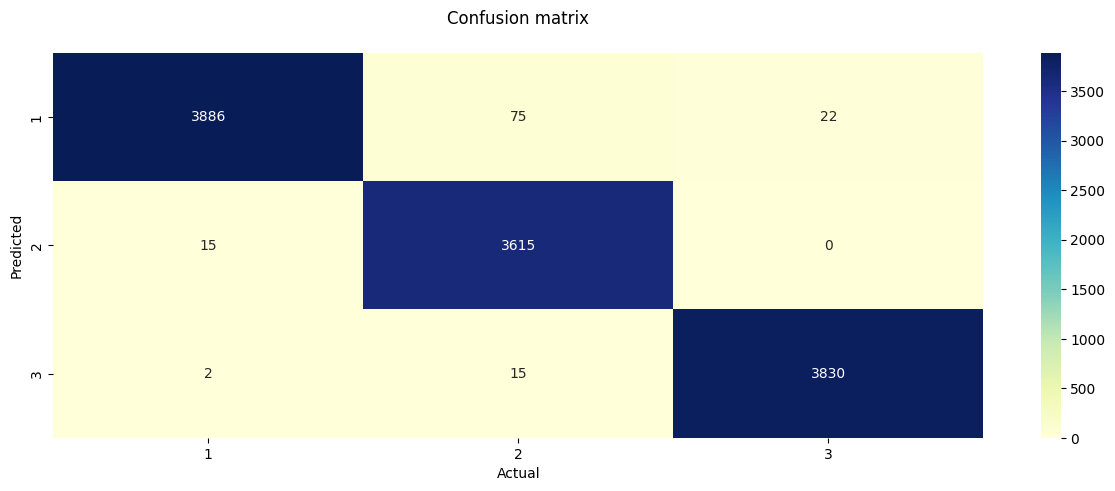

In [30]:
# Plot confusion matrix for planetscope data here
hp.conf_mat(model, test_images, test_labels)

## Load in the naip data and create a simple CNN with it.

In [31]:
naip_images_tif, naip_labels_tif = hp.dataset_reader_naip('naip_2018_chips_90m_3class_classified_tiles')

reading in 30444 images
read in 30441 valid images and labels


In [32]:
np.unique(naip_labels_tif, axis=0, return_counts=True)

(array([1, 2, 3], dtype=uint16), array([ 6204,   319, 23918]))

In [33]:
# Shuffle labels and images and create a train test split for NAIP data
train_images, test_images, train_labels, test_labels = train_test_split(naip_images_tif, naip_labels_tif, test_size=.2, shuffle=True)

## Do oversampling and data augmentation for NAIP data

In [34]:
# Map images and labels using pandas dataframe
df_dict = {"images": [], "labels": []}

for i in range(len(train_images)):
    df_dict["images"].append(train_images[i])
    df_dict["labels"].append(train_labels[i])

df = pd.DataFrame(data=df_dict)

label_1_rows = df.loc[df['labels'] == 1]
label_2_rows = df.loc[df['labels'] == 2]
label_3_rows = df.loc[df['labels'] == 3]

print(len(label_1_rows))
print(len(label_2_rows))
print(len(label_3_rows))

4966
253
19133


In [35]:
# Oversample and data augment images from labels 1 and 2 for naip
new_L1_df = hp.augment_label_1(label_1_rows)
print("New label 1 images:", len(new_L1_df))

new_L2_df = hp.augment_label_2(label_2_rows)
print("New label 2 images", len(new_L2_df))

L1_L2 = pd.concat([new_L1_df, new_L2_df], ignore_index=True)
new_df = pd.concat([L1_L2, label_3_rows], ignore_index=True)

L1_L2 = pd.concat([new_L1_df, new_L2_df], ignore_index=True)
new_df = pd.concat([L1_L2, label_3_rows], ignore_index=True)

New label 1 images: 19864
New label 2 images 20240


In [36]:
# Get new naip images and labels from new dataframe
comb_naip_images = []
comb_naip_labels = []

for index, row in new_df.iterrows():
    new_image = row["images"]
    new_label = row["labels"]

    comb_naip_images.append(new_image)
    comb_naip_labels.append(new_label)

comb_naip_images = np.asarray(comb_naip_images)
comb_naip_labels = np.asarray(comb_naip_labels)

In [37]:
# Encode naip data
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(comb_naip_labels.reshape(-1, 1))
naip_new_labels = enc.transform(comb_naip_labels.reshape(-1, 1)).toarray().astype('uint8')

print(comb_naip_labels[0])
print(comb_naip_labels.shape)

1
(59237,)


In [51]:
# Do a train_test_split with oversampled and augmented data for naip
train_images, test_images, train_labels, test_labels = train_test_split(comb_naip_images, naip_new_labels, test_size=.2, shuffle=True)

In [39]:
np.unique(train_labels, axis=0, return_counts=True)

(array([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]], dtype=uint8),
 array([15300, 16193, 15896]))

In [40]:
# Create a simple model for the NAIP data 
model = hp.get_simple_model(train_images[0].shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 90, 90, 50)        5050      
                                                                 
 batch_normalization_4 (Batc  (None, 90, 90, 50)       200       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 45, 45, 50)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 30)        37530     
                                                                 
 batch_normalization_5 (Batc  (None, 45, 45, 30)       120       
 hNormalization)                                                 
                                                      

In [41]:
# Calculate initial test accuracy for NAIP data
test_init = hp.get_test_accuracy(model, test_images, test_labels)
train_init = hp.get_train_accuracy(model, train_images, train_labels)

accuracy: 0.328
accuracy: 0.328


In [42]:
# Train model with NAIP data
history = model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels))

Epoch 1/30
1481/1481 [==============================] - 18s 12ms/step - loss: 0.2167 - accuracy: 0.9161 - val_loss: 1.9078 - val_accuracy: 0.5799
Epoch 2/30
1481/1481 [==============================] - 16s 11ms/step - loss: 0.0828 - accuracy: 0.9714 - val_loss: 0.0819 - val_accuracy: 0.9765
Epoch 3/30
1481/1481 [==============================] - 17s 11ms/step - loss: 0.0429 - accuracy: 0.9861 - val_loss: 0.2176 - val_accuracy: 0.9238
Epoch 4/30
1481/1481 [==============================] - 17s 12ms/step - loss: 0.0325 - accuracy: 0.9888 - val_loss: 0.0270 - val_accuracy: 0.9905
Epoch 5/30
1481/1481 [==============================] - 17s 12ms/step - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.0570 - val_accuracy: 0.9823
Epoch 6/30
1481/1481 [==============================] - 17s 12ms/step - loss: 0.0147 - accuracy: 0.9951 - val_loss: 0.3907 - val_accuracy: 0.8978
Epoch 7/30
1481/1481 [==============================] - 17s 12ms/step - loss: 0.0202 - accuracy: 0.9929 - val_loss: 0.0808 -

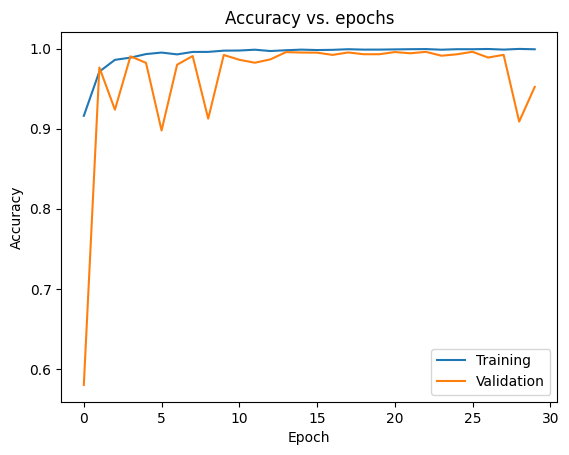

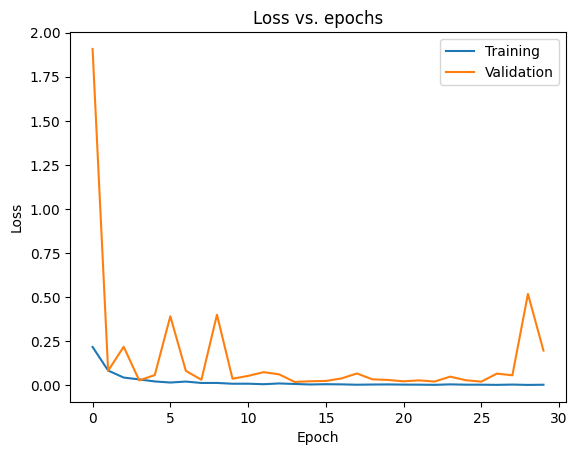

In [43]:
# Plot accuracy for NAIP data
hp.plot_accuracy(history)
hp.plot_loss(history)

In [44]:
# Get accuracy after training the NAIP model once
test_first = hp.get_test_accuracy(model, test_images, test_labels)
train_first = hp.get_train_accuracy(model, train_images, train_labels)

accuracy: 0.952
accuracy: 0.963


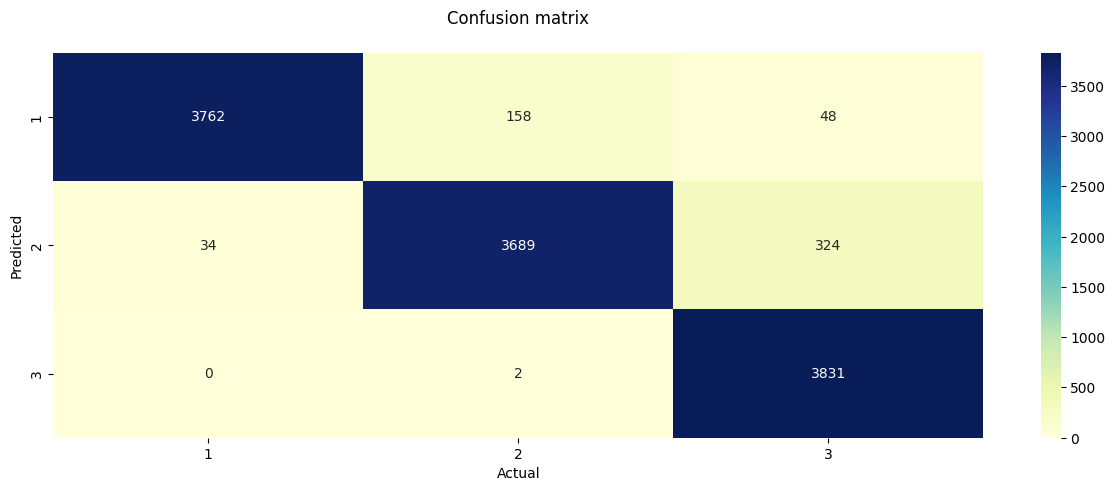

In [45]:
# Plot confusion matrix for naip data here
hp.conf_mat(model, test_images, test_labels)

## Make TL model for NAIP Data Here

In [59]:
img = train_images[0]
img = img[:,:,:3]
print(img.shape)
tl_model = hp.get_TL_model(img.shape)
tl_model.summary()

(90, 90, 3)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_12 (Dense)            (None, 64)                131136    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 3)                 195       
                                                                 
Total params: 23,719,043
Trainable params: 131,331
Non-trainable params: 23,587,712
_________________________________________________________________


In [52]:
test_images = test_images[:,:,:,0:3]
train_images = train_images[:,:,:,0:3]

print(test_images[0].shape)
print(train_images[0].shape)

(90, 90, 3)
(90, 90, 3)


In [60]:
# Calculate initial test accuracy for NAIP data with tl_model
test_init = hp.get_test_accuracy(tl_model, test_images, test_labels)
train_init = hp.get_train_accuracy(tl_model, train_images, train_labels)

accuracy: 0.291
accuracy: 0.291


In [61]:
# Train TL model with NAIP data
history = tl_model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels))

Epoch 1/30
1481/1481 [==============================] - 35s 23ms/step - loss: 0.3341 - accuracy: 0.8621 - val_loss: 0.2312 - val_accuracy: 0.9002
Epoch 2/30
1481/1481 [==============================] - 33s 22ms/step - loss: 0.2282 - accuracy: 0.9090 - val_loss: 0.1721 - val_accuracy: 0.9360
Epoch 3/30
1481/1481 [==============================] - 33s 22ms/step - loss: 0.1910 - accuracy: 0.9253 - val_loss: 0.1390 - val_accuracy: 0.9489
Epoch 4/30
1481/1481 [==============================] - 33s 22ms/step - loss: 0.1658 - accuracy: 0.9364 - val_loss: 0.1234 - val_accuracy: 0.9543
Epoch 5/30
1481/1481 [==============================] - 33s 22ms/step - loss: 0.1487 - accuracy: 0.9443 - val_loss: 0.1139 - val_accuracy: 0.9590
Epoch 6/30
1481/1481 [==============================] - 33s 22ms/step - loss: 0.1360 - accuracy: 0.9483 - val_loss: 0.1089 - val_accuracy: 0.9658
Epoch 7/30
1481/1481 [==============================] - 33s 22ms/step - loss: 0.1217 - accuracy: 0.9549 - val_loss: 0.0913 -

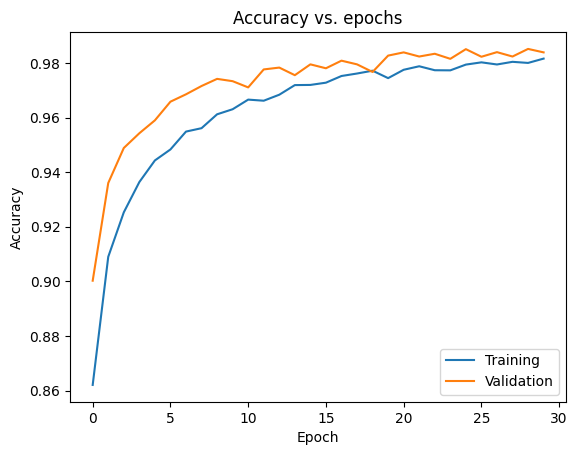

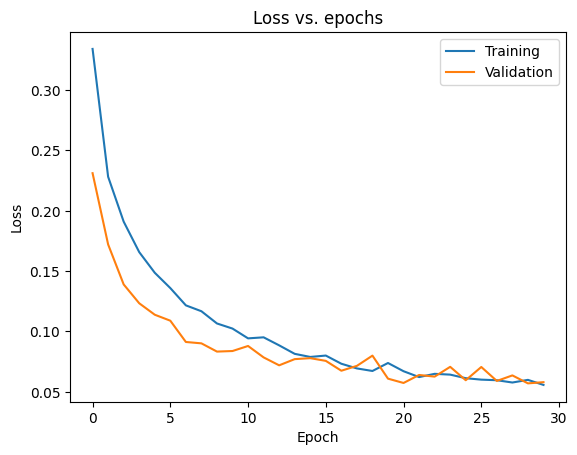

In [62]:
# Plot accuracy for NAIP data with TL model
hp.plot_accuracy(history)
hp.plot_loss(history)

In [65]:
# Get accuracy after training the NAIP model once with TL model
test_first = hp.get_test_accuracy(tl_model, test_images, test_labels)
train_first = hp.get_train_accuracy(tl_model, train_images, train_labels)

accuracy: 0.984
accuracy: 0.995


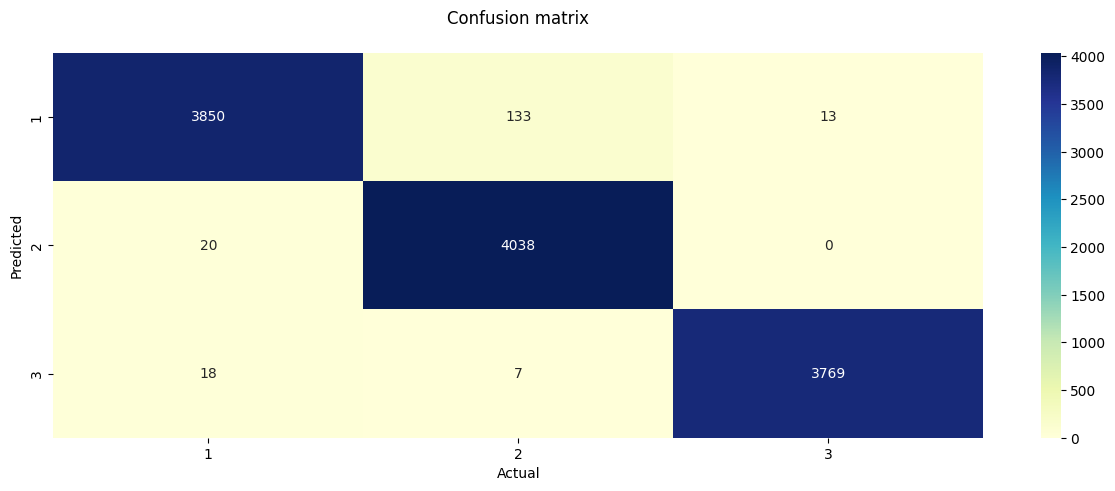

In [64]:
# Plot confusion matrix for naip data here
hp.conf_mat(tl_model, test_images, test_labels)